In [25]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pylab as plt

%load_ext rpy2.ipython
import pandas as pd
import numpy as np

import os
os.chdir("/Users/lucapozzi/repos/Arlem/")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Generate Data

In [26]:
from harlem.data.data_generator import DataGeneratorHarlem

In [27]:
%%capture
data_gen = DataGeneratorHarlem()

In [28]:
# [1] -0.36068676  0.01080478
data_gen.theta

array([-0.35714169,  0.0106924 ])

In [29]:
full_data, _ = data_gen.data_generator(5000)

seed: 1544733610


In [30]:
delta_star = max(np.abs(np.diff(sorted(full_data.w))))
print(delta_star)

0.7316741224412766


## Test vs. R

In [31]:
n_grid = 300
tau = 100

In [32]:
%%R -i full_data -i n_grid -i tau

library("HARLEM")
library("splines")

lambdaConst <- function(tau){
    function(x){
        if(x<10)return(0)
        if(x>70)return(0)
        return(1)
    }
}
lambdaConst <- Vectorize(lambdaConst(tau))


dataGen <- dataGenHARLEM(delta=3, 100, lambda=lambdaConst,rate=0.017)
truth <- dataGen$theta
print(truth)

truth <- dataGen$theta
lambda <- dataGen$lambda
nGrid <- 300


xGrid <- seq(0,tau,length.out=n_grid)
vGrid <- seq(0,tau,length.out=n_grid)


deltaStar <- max(diff(sort(full_data$w)))
print(deltaStar)

/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[1] -0.36068676  0.01080478
[1] 0.7316741


In [33]:
data_gen.theta

array([-0.35714169,  0.0106924 ])

/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


seed:[1] -1109744126


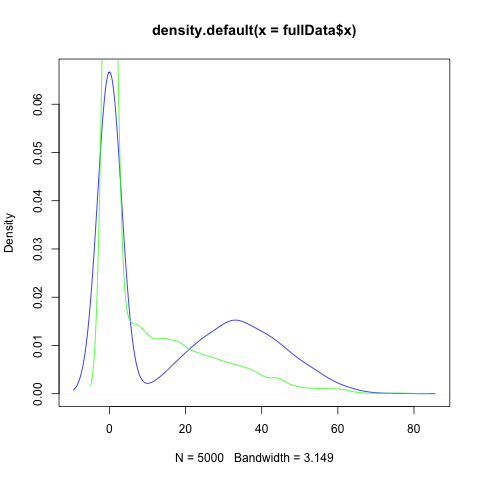

In [34]:
%%R -i full_data
fullData <- dataGen$simHARLEM(nrow(full_data)) 
plot(density(fullData$x), col='blue')
lines(density(full_data$x), col='green')

seed:[1] 1732096778


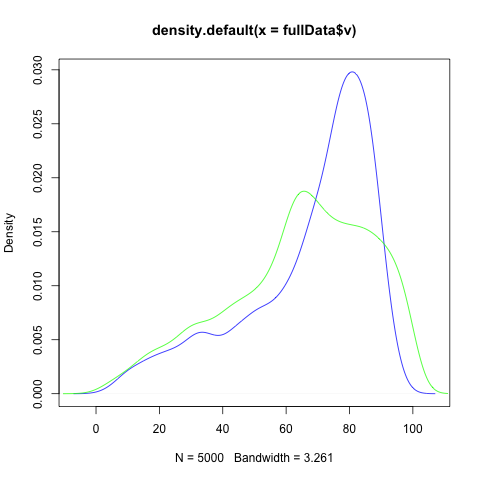

In [35]:
%%R
fullData <- dataGen$simHARLEM(nrow(full_data)) 
plot(density(fullData$v), col='blue')
lines(density(full_data$v), col='green')

## Initialization

In [36]:
x_grid = np.linspace(0, tau, num=n_grid)
v_grid = np.linspace(0, tau, num=n_grid)

### Q's

In [37]:
from harlem.parameters.init_Q import init_Q

In [38]:
%%time
# Normalization Constant: [1] 1.178421
Q0 = init_Q(full_data, x_grid, v_grid, delta_star, tau=tau, verbose=True)
Q1, Q2 = Q0

h Opt [2.35664801 1.48697685]
Renormalization Constant: 0.945947663895417
CPU times: user 1min 3s, sys: 765 ms, total: 1min 4s
Wall time: 1min 9s


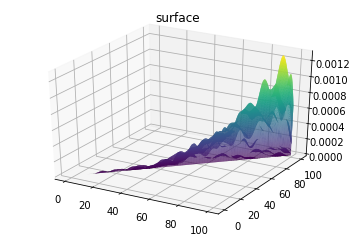

In [39]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.plot_surface(x_grid, v_grid, Q2, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');


In [40]:
%%R
#source("~/repos/HARLEM/R/initFun.R")
cat("Initializing the Q's...\n")
Q0 <- initQ(full_data,xGrid,vGrid, deltaStar,tau=tau, verbose=TRUE); Q1 <- Q0[[1]]; Q2 <- Q0[[2]]
Sn <- Q1$Sn; Qc <- Q1$Qc; dGn <- Q1$dGn
hOpt <- attr(Q2,"hOpt")

Initializing the Q's...
a= -6.501876  b= 4.370399 
c= 1.053807  d= 4.589837 

****
h Opt.[1] 0.05 0.05
Normalization Constant: [1] 1.130415


$Q_1$ is on top (close enough...)

In [41]:
print(Q1['Sn'](50))
print(Q1['dGn'][:5])
print(Q1['Qc'](60))

0.4821621953652026
[0.00026439 0.00011274 0.00086498 0.00010979 0.0001199 ]
0.28813308562120793


In [42]:
%%R
print(Q0[[1]]$Sn(50))
print(Q0[[1]]$dGn[1:5])
print(Q0[[1]]$Qc(60))

[1] 0.4821622
[1] 0.0002643878 0.0001127440 0.0008649766 0.0001097911 0.0001198963
[1] 0.2881331


$Q_2$ is a bit off...

In [43]:
(Q2==0).mean()

0.5083

In [44]:
%R mean(Q0[[2]]==0)

array([0.72291111])

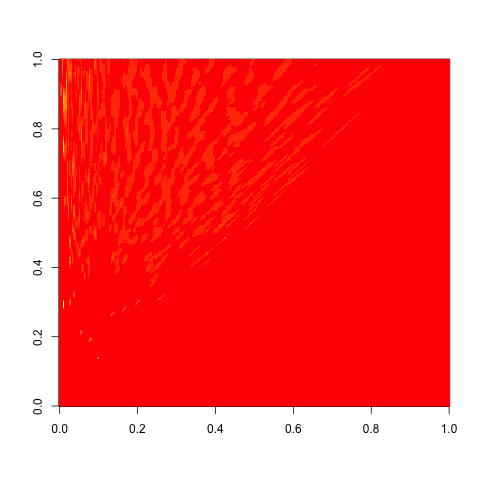

In [45]:
%%R -i Q2
image(t(Q0[[2]]) - Q2)

In [46]:
%R max(Q0[[2]])

array([0.00479243])

In [47]:
Q2.max()

0.0012913771860334734

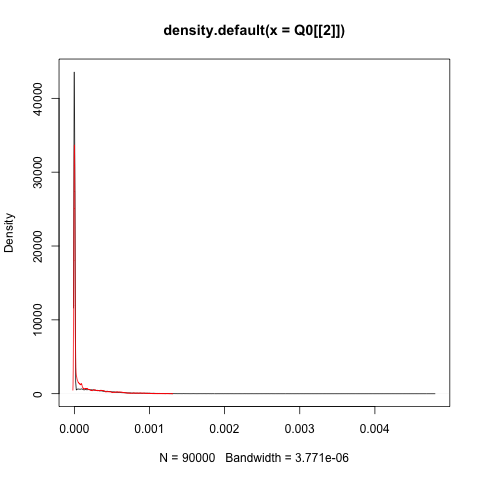

In [48]:
%%R
plot(density(Q0[[2]]))
lines(density(Q2), col='red')

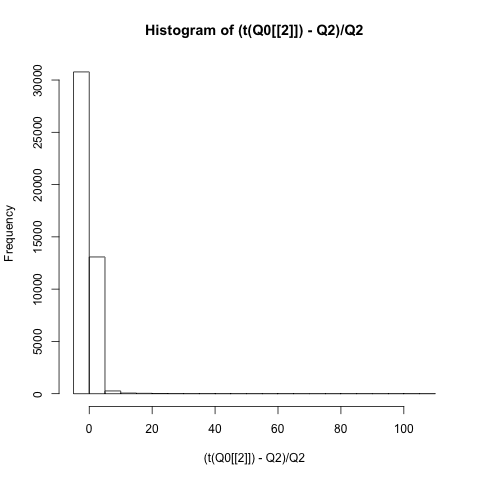

In [49]:
%%R
hist((t(Q0[[2]]) - Q2)/Q2)

In [50]:
%R hOpt

array([0.05, 0.05])

### T's

In [51]:
from harlem.parameters.init_T import init_T

In [164]:
%%time
T0 = init_T(full_data, Q1['Qc'], Q1['dGn'], delta_star, x_grid, v_grid)
T1, T2 = T0

CPU times: user 7.13 s, sys: 42 ms, total: 7.18 s
Wall time: 7.24 s


In [53]:
print((T1==0).mean(), (T1!=0).sum())
print((T2==0).mean(), (T2!=0).sum())

0.5083 44253
0.5083 44253


In [54]:
%%R
cat("Initializing the T's...\n")
T0 <- initT(full_data,Qc,dGn,deltaStar,xGrid,vGrid); T1 <- T0[[1]]; T2 <- T0[[2]]

Initializing the T's...


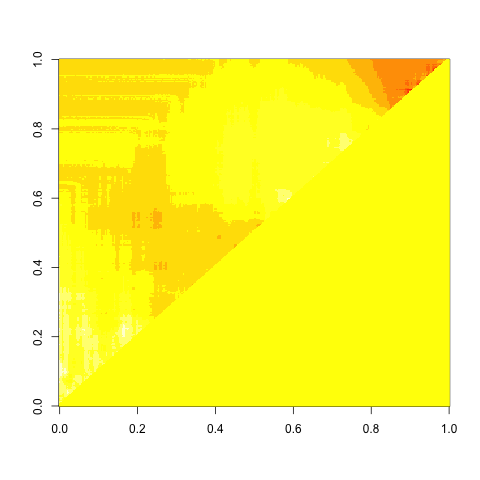

In [55]:
%%R -i T1
image(t(T0[[1]]) - T1)

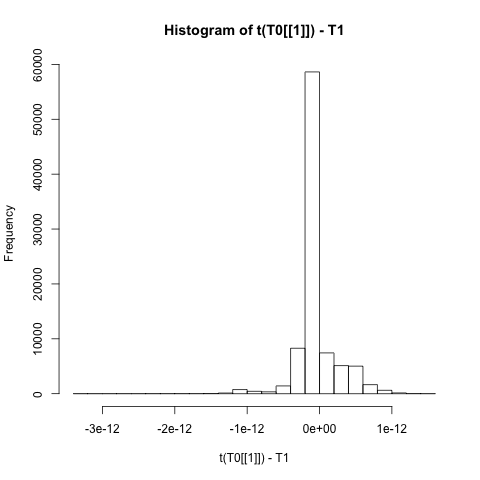

In [56]:
%%R
hist(t(T0[[1]]) - T1)

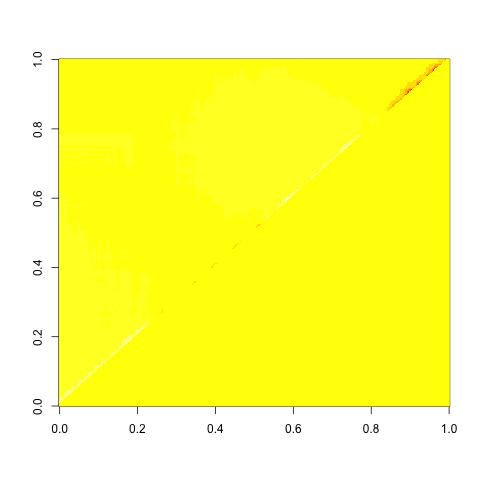

In [57]:
%%R -i T2
image(t(T0[[2]]) - T2)

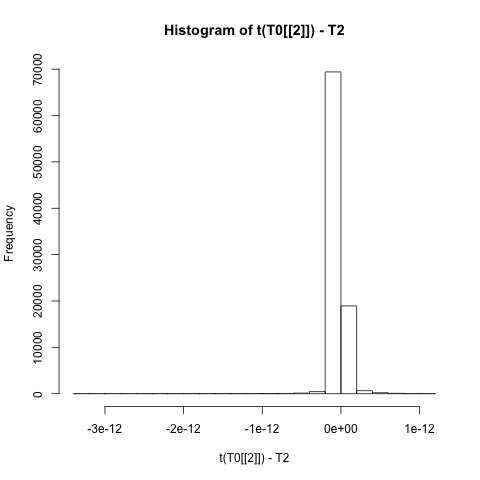

In [58]:
%%R
hist(t(T0[[2]]) - T2)

In [59]:
%%R
print(mean(t(T0[['T1']]) - T1))
print(max(t(T0[['T1']]) - T1))

[1] 6.101115e-15
[1] 1.435296e-12


In [60]:
%%R
print(mean(t(T0[['T2']]) - T2))
print(max(t(T0[['T2']]) - T2))

[1] 1.734117e-15
[1] 1.080025e-12


## Initial Estimator

In [61]:
%%capture
from harlem.estimator.linear_estimator import LinearEstimator

linear_estimator = LinearEstimator(full_data, T1, T2, Q1,
                                   x_grid, v_grid, delta_star)
theta_linear = linear_estimator.psi(Q2)

In [62]:
theta_linear

array([-0.57267211,  0.01527397])

In [63]:
%%R -i T1 -i T2 -i Q2
cat(("Initializing  Psi...\n"))
initPsi <- linearPsi(full_data,deltaStar,tau)(t(T1),t(T2),Q1,t(Q2),lambdaConst,xGrid,vGrid)
initPsi

Initializing  Psi...
[1] -0.57304054  0.01521251


In [64]:
%%R 
cat(("Initializing  Psi...\n"))
initPsi <- linearPsi(full_data,deltaStar,tau)(T0[[1]],T0[[2]],Q1,Q0[[2]],lambdaConst,xGrid,vGrid)
initPsi

Initializing  Psi...
[1] -0.48100603  0.01164728


- TODO: Constant estimator

## Debias

### One Step Estimator

In [65]:
%%capture
from harlem.estimator.debias.one_step import HarlemOneStep
one_step = HarlemOneStep(full_data=full_data, delta_star=delta_star, T0=T0, Q0=Q0)

In [66]:
theta_one_step = one_step.fit()
theta_one_step

[-1.10177765e-05  5.23328596e-07]


array([-0.57266109,  0.01527345])

In [67]:
one_step.init_psi

array([-0.57267211,  0.01527397])

In [39]:
theta_linear

array([-0.42639545,  0.01043633])

In [81]:
%%R
library(HARLEM)
cat("Running One Step...\n")
one_step <- harlem1Step(full_data,linearPsi(full_data,deltaStar,tau),deltaStar,tau,nGrid,
                        lambda=Vectorize(function(x)1*((x>=10)&(x<=70))),
                        Q0=list(Q1=Q1, Q2=t(Q2)),T0=list(T1=t(T1), T2=t(T2)))
one_step

Running One Step...
            [,1]
[1,] -3.16011859
[2,]  0.04160081


In [82]:
%%R -i Q2
cat("Running One Step...\n")
one_step <- harlem1Step(full_data,linearPsi(full_data,deltaStar,tau),deltaStar,tau,nGrid,
                        lambda=Vectorize(function(x)1*((x>=10)&(x<=70))),
                        Q0=Q0,T0=T0)
one_step

Running One Step...
             [,1]
[1,] -0.386311013
[2,]  0.007732255


### TMLE

In [92]:
%%capture
from harlem.estimator.debias.tmle import HarlemTMLE
tmle = HarlemTMLE(full_data=full_data, delta_star=delta_star, Q0=Q0, T0=T0, verbose=True)

In [93]:
%%time
tmle.fit()

0 Epsilon: [-3.33330660e-05  5.61812985e-07]
Log-likelihood: -7.888470034330619
Renormalization Constant: 1.0
D: [-0.11932577  0.1570381 ], |  log-Likelihood = -7.888470034330619
Stopping: 0.15703809567635035 - 0.022541740866685808
1 Epsilon: [-3.29588105e-05  5.56080981e-07]
Log-likelihood: -7.888480645703195
Renormalization Constant: 1.0
D: [-0.1192395   0.15652423], |  log-Likelihood = -7.888480645703195
Stopping: 0.1565242292891898 - 0.022541740866685808
2 Epsilon: [-3.25970349e-05  5.50622697e-07]
Log-likelihood: -7.888491510094416
Renormalization Constant: 1.0
D: [-0.11915337  0.15601981], |  log-Likelihood = -7.888491510094416
Stopping: 0.15601980889267322 - 0.022541740866685808
3 Epsilon: [-3.22544931e-05  5.45311031e-07]
Log-likelihood: -7.888502610383162
Renormalization Constant: 1.0
D: [-0.11906763  0.15552447], |  log-Likelihood = -7.888502610383162
Stopping: 0.1555244682238412 - 0.022541740866685808
4 Epsilon: [-3.19238365e-05  5.40248953e-07]
Log-likelihood: -7.8885139644

KeyboardInterrupt: 

In [95]:
%%capture
from harlem.estimator.debias.tmle import HarlemTMLE
from harlem.estimator.train.step_constant import StepConstant
from harlem.estimator.constant_estimator import ConstantEstimator
tmle = HarlemTMLE(full_data=full_data, delta_star=delta_star, 
                  target_step=StepConstant,
                  estimator=ConstantEstimator,
                  Q0=Q0, T0=T0, verbose=True)
tmle.fit()

KeyboardInterrupt: 

In [ ]:
%%R
cat("Running TMLE...\n")
TMLE <- harlemTMLE(full_data,stepLinear(full_data, deltaStar,tau,lambdaConst,1/sqrt(nrow(obsData))),
                   linearPsi(full_data,deltaStar,tau), deltaStar,tau,nGrid=nGrid, Q0=Q0,T0=T0)

In [1]:
%R names(TMLE)

UsageError: Line magic function `%R` not found.


In [2]:
%R TMLE[['Q2']]

UsageError: Line magic function `%R` not found.


In [277]:
%R TMLE[['thetaHat']]

array([[-0.52126093, -1.00357283],
       [ 0.01160983,  0.02329393]])

## True Parameters

In [92]:

import numpy as np
from harlem.data.harlem_copula import HarlemCopula
from scipy.stats import beta, expon

joint_distribution = HarlemCopula()
rate = 0.017

tau = 100
delta = 3
n_grid = 300
nsimMC = 1e7
batch = 1e4

x_grid = np.linspace(0, tau, num=n_grid)
v_grid = np.linspace(0, tau, num=n_grid)


In [116]:
real_G = np.vectorize(lambda w: beta.cdf(w/tau,a=5,b=3.7))
real_dG = np.vectorize(lambda w: beta.pdf(w/tau,a=5,b=3.7))
real_w = tau*beta.rvs(size=50000,a=5,b=3.7)

### Exact Q1

In [94]:
true_Qc = np.vectorize(lambda x: 1 - expon.cdf(x, loc=1/rate))
true_dGn = np.vectorize(lambda w: beta.pdf(w/tau, a=1, b=1))

def exact_Sz(tau):
    return lambda u: 1 - joint_distribution.cdf(u / tau, 1)

true_Sz = np.vectorize(exact_Sz(tau))

In [130]:
true_Q1 = {'Sn': true_Sz, 'dGn': true_dGn, 'Qc': true_Qc}

### Exact Q2

In [82]:
def exact_normalization(n):
    z, x = tau*joint_distribution.rvs(n)
    return (tau ** 2) * np.mean((x+delta < z) * (1 - np.exp(-rate * (z-x))))

batch_size = int(np.ceil(nsimMC / batch))
normConst = np.array([exact_normalization(int(batch)) for i in range(batch_size)]).mean()

In [83]:
normConst

2405.7634125981003

In [84]:
def exact_Q2(x, v):

    res = (x + delta < v) * (1 - np.exp(-rate * (v - x))) * joint_distribution.pdf([x / tau, v / tau]) / normConst

    if res is np.nan:
        return 0.

    return res

true_Q2 = np.vectorize(exact_Q2)(x_grid[:, None], v_grid)

### Exact T's

In [87]:
def exact_T1(x, v):
    if v > x + delta:
        return (v - x) / (1 - np.exp(-rate * (v - x)))
    else:
        return 0

def exact_T2(x, v):
    if v > x + delta:
        return 1 / (1 -np. exp(-rate * (v - x)))
    else:
        return 0

true_T1 = np.vectorize(exact_T1)(x_grid[:, None], v_grid)
true_T2 = np.vectorize(exact_T2)(x_grid[:, None], v_grid)


In [145]:
print((np.abs(T1 - true_T1)[true_T1!=0]/true_T1[true_T1!=0]).max())
print((np.abs(T2 - true_T2)[true_T2!=0]/true_T2[true_T2!=0]).max())
print((np.abs(Q2 - true_Q2)[true_Q2!=0]/true_Q2[true_Q2!=0]).max())

1.6338648876993223
1.6847463684844177
1.2125607623500998e+20


### Testing Estimates

In [131]:
%%capture
true_estimator = LinearEstimator(full_data, true_T1, true_T2, true_Q1,
                                 x_grid, v_grid, delta_star)
true_estimate = true_estimator.psi(true_Q2)

In [132]:
true_estimate

array([-0.92839344,  0.01805589])

In [122]:
theta_linear

array([-0.57267211,  0.01527397])

In [117]:
estimated_dGn = np.cumsum(np.diff(1/Q1['Sn'](sorted(full_data.w))))
estimated_G = np.cumsum(np.array(sorted(zip(full_data.w, Q1['dGn'])))[:,1])

In [157]:
real_dG(40)

array(1.37333682)

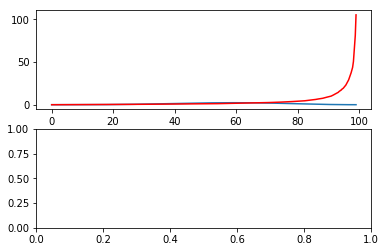

In [159]:
fig, axes = plt.subplots(nrows=2, ncols=1) #, figsize=figsize)
w_w = np.linspace(full_data.w.min(), full_data.w.max(), num=1000)
axes[0].plot(w_w, real_dG(w_w))
axes[0].plot(sorted(full_data.w),Q1['dGn'],c="red")

axes[1].plot(w_w, real_dG(w_w))
axes[1].plot(sorted(full_data.w),Q1['dGn'],c="red")

In [ ]:
par(mfrow=c(1,2))
plot(realdG,xlim=range(w),col="green")#,add=TRUE
lines(sort(w),dGn,col="red",type="l")
plot(realG,xlim=range(w))#,add=TRUE
lines(sort(w),estG,col="red")

lines(sort(w),pbeta(sort(w)/tau,5,3.7))

plot(realQc,xlim=c(10,70))
plot(Qc,add=TRUE,col="red",xlim=c(10,70))
plot(qc,add=TRUE,col="blue",xlim=c(10,70))


plot(ecdf(w))
plot(ecdf(wReal))

